In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"


# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
from pathlib import Path

np.random.seed(42)
tf.random.set_seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)


In [2]:
DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

1065304064/1065301781 [==============================] - 12s 0us/step


In [3]:
from pathlib import Path
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [4]:
train_files

['/root/.keras/datasets/quickdraw/training.tfrecord-00000-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00001-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00002-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00003-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00004-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00005-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00006-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00007-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00008-of-00010',
 '/root/.keras/datasets/quickdraw/training.tfrecord-00009-of-00010']

In [5]:
eval_files

['/root/.keras/datasets/quickdraw/eval.tfrecord-00000-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00001-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00002-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00003-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00004-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00005-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00006-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00007-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00008-of-00010',
 '/root/.keras/datasets/quickdraw/eval.tfrecord-00009-of-00010']

In [6]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [7]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [8]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [9]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [10]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [11]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [12]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("=====================================")
    print("lengths =", lengths)
    print("=====================================")
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.0944882  -0.04663213  0.        ]
  [-0.08661417  0.04145078  0.        ]
  [-0.03937007  0.05181348  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.04313726 -0.14960629  0.        ]
  [ 0.06274509 -0.40551183  0.        ]
  [ 0.04313726 -0.12598425  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          1.        ]
  [ 0.          0.          0.        ]
  [-0.19607842 -0.03174603  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.12790698  0.01960784  0.        ]
  [-0.02906978  0.2117647   0.        ]
  [-0.04651159  0.06274509  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

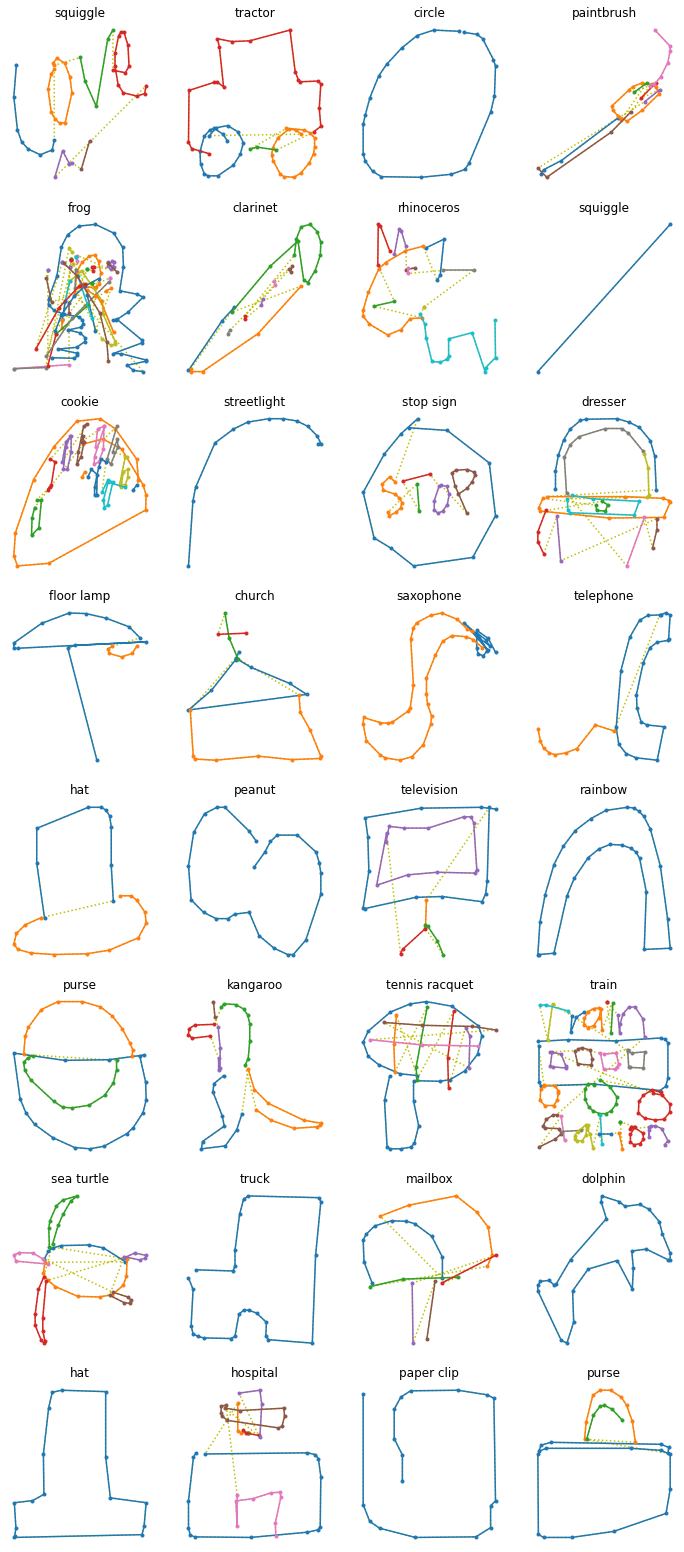

In [13]:
import matplotlib.pyplot as plt
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

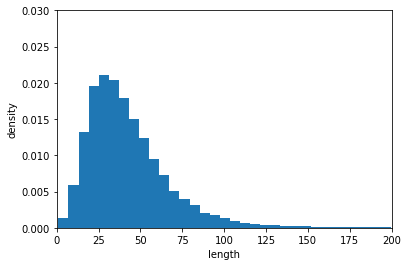

In [14]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [15]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [16]:
model = keras.models.Sequential([
    keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                     validation_data=cropped_valid_set)
                  

Epoch 1/2
107813/107813 [==============================] - 1757s 16ms/step - loss: 4.1334 - accuracy: 0.1625 - sparse_top_k_categorical_accuracy: 0.3625 - val_loss: 3.0804 - val_accuracy: 0.3124 - val_sparse_top_k_categorical_accuracy: 0.5950
Epoch 2/2
107813/107813 [==============================] - 1755s 16ms/step - loss: 2.7359 - accuracy: 0.3742 - sparse_top_k_categorical_accuracy: 0.6630 - val_loss: 2.4854 - val_accuracy: 0.4211 - val_sparse_top_k_categorical_accuracy: 0.7088


In [17]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

In [18]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.5970683

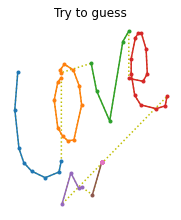

Top-5 predictions:
  1. blueberry 22.930%
  2. animal migration 10.340%
  3. eyeglasses 8.574%
  4. peas 7.167%
  5. sun 5.114%
Answer: squiggle


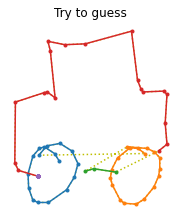

Top-5 predictions:
  1. tractor 48.421%
  2. police car 10.311%
  3. rollerskates 7.806%
  4. motorbike 7.160%
  5. car 6.335%
Answer: tractor


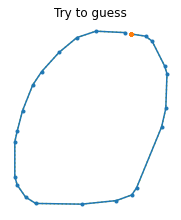

Top-5 predictions:
  1. ear 21.880%
  2. moon 19.823%
  3. onion 11.966%
  4. hexagon 6.331%
  5. circle 5.415%
Answer: circle


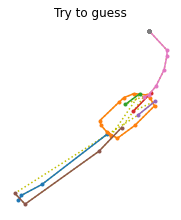

Top-5 predictions:
  1. see saw 18.137%
  2. yoga 6.139%
  3. matches 5.811%
  4. blueberry 3.438%
  5. beach 3.188%
Answer: paintbrush


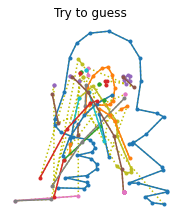

Top-5 predictions:
  1. spider 10.265%
  2. lobster 5.067%
  3. hedgehog 4.057%
  4. snowflake 3.980%
  5. light bulb 3.864%
Answer: frog


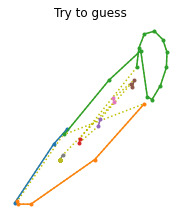

Top-5 predictions:
  1. garden hose 17.174%
  2. toothbrush 12.789%
  3. remote control 8.340%
  4. string bean 6.507%
  5. beach 3.842%
Answer: clarinet


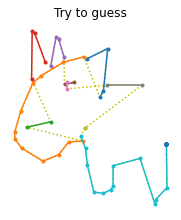

Top-5 predictions:
  1. giraffe 23.526%
  2. animal migration 14.256%
  3. stethoscope 6.022%
  4. scorpion 5.826%
  5. flamingo 3.068%
Answer: rhinoceros


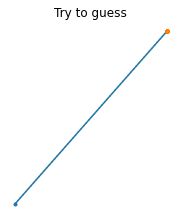

Top-5 predictions:
  1. line 34.127%
  2. ant 6.695%
  3. stitches 3.921%
  4. mosquito 2.773%
  5. rain 2.447%
Answer: squiggle


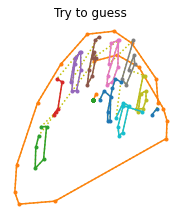

Top-5 predictions:
  1. peas 30.212%
  2. toe 17.400%
  3. cookie 5.635%
  4. bracelet 4.822%
  5. remote control 3.516%
Answer: cookie


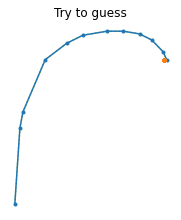

Top-5 predictions:
  1. streetlight 15.117%
  2. finger 11.667%
  3. spoon 7.546%
  4. nail 6.627%
  5. bread 4.816%
Answer: streetlight


In [19]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))